# Importing Libraries.

In [1]:
import numpy as np
import cv2
import scipy.io
import glob
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
np.random.seed(0)

In [2]:
def loadDataset(path):
    print('Loading Dataset...')
    train_x, train_y, test_x, test_y = [], [], [], []
    for i in range(10):
        for filename in glob.glob(path + '\\train\\' + str(i)+'\\*.png'):
            im=cv2.imread(filename)
            im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
            train_x.append(im)
            train_y.append(i)
    for i in range(10):
        for filename in glob.glob(path + '\\test\\' + str(i)+'\\*.png'):
            im=cv2.imread(filename)
            im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
            test_x.append(im)
            test_y.append(i)
    print('Dataset loaded...')
    return np.array(train_x), np.array(train_y), np.array(test_x),np.array(test_y)

# Data Loading

In [3]:
train_set_x1, train_set_y1, test_set_x1, test_set_y1  = loadDataset(r'C:\Users\Mudasser Afzal\Desktop\deep ass 3')

Loading Dataset...
Dataset loaded...


In [4]:
train_set_x, train_set_y, test_set_x, test_set_y = train_set_x1, train_set_y1, test_set_x1, test_set_y1

In [5]:
print("train_x shape:", train_set_x.shape)
print("train_y shape:", train_set_y.shape)
print("test_x shape:", test_set_x.shape)
print("test_y shape:", test_set_y.shape)

train_x shape: (60000, 28, 28)
train_y shape: (60000,)
test_x shape: (10000, 28, 28)
test_y shape: (10000,)


In [6]:
train_set_x, train_set_y = shuffle(train_set_x, train_set_y)

# reshape and Flattening Data

In [7]:
train_set_y = np.expand_dims(train_set_y, axis = 1)
test_set_y = np.expand_dims(test_set_y, axis=1)

In [8]:
print("train_x shape:", train_set_x.shape)
print("train_y shape:", train_set_y.shape)
print("test_x shape:", test_set_x.shape)
print("test_y shape:", test_set_y.shape)

train_x shape: (60000, 28, 28)
train_y shape: (60000, 1)
test_x shape: (10000, 28, 28)
test_y shape: (10000, 1)


# Mean subtraction and normalization

In [9]:
train_set_x = (train_set_x - int(np.mean(train_set_x))) / 255
test_set_x = (test_set_x - int(np.mean(test_set_x))) / 255

# Encoding of labels

In [10]:
def encoder(Y):
    c = np.arange(10)
    encoding = (c == Y).astype(np.int)
    return encoding

train_set_y = encoder(train_set_y)
test_set_y = encoder(test_set_y)

In [11]:
print("train_x shape:", train_set_x.shape)
print("train_y shape:", train_set_y.shape)
print("test_x shape:", test_set_x.shape)
print("test_y shape:", test_set_y.shape)

train_x shape: (60000, 28, 28)
train_y shape: (60000, 10)
test_x shape: (10000, 28, 28)
test_y shape: (10000, 10)


# reading filters

In [12]:
data = scipy.io.loadmat('filters.mat')
filters = data['filters']
filters = np.array(filters)
print(filters.shape)

(17, 17, 36)


In [26]:
# depth = filters.shape[2]
# for i in range(depth):
#     plt.subplot(5,8,i+1)
#     plt.axis('off')
#     plt.imshow(filters[:,:,i])

# Convolution and Pooling

In [16]:
def conv_single_step(image, filter):
    s = np.multiply(image, filter)
    Z = np.sum(s)
    return Z

In [17]:
def conv_forward(img, filters, stride=1, pad=0):
#     print(img.shape)
    output_size_H = int(((img.shape[1] - len(filters) + (2 * pad)) / (stride)) + 1)
    output_size_W = int(((img.shape[0] - len(filters) + (2 * pad)) / (stride)) + 1)
#     print("the shape of output will be :", output_size_H, output_size_W)

    Z = np.zeros([output_size_H, output_size_W, filters.shape[2]])
    for d in range(filters.shape[2]):
        a = filters[:,:,d]
        for j in range(0, output_size_H):
            for k in range(0, output_size_W):
                img_patch = img[(j*stride):(j*stride)+(filters.shape[1]), (k*stride):(k*stride)+(filters.shape[0])]
                Z[j, k, d] = conv_single_step(img_patch, a)

    return Z

def pool_forward(feature_map, mode = "max", filter_size=2, stride=2):
    
    pool_size_H = int(((feature_map.shape[0] - filter_size) / (stride)) + 1)
    pool_size_W = int(((feature_map.shape[1] - filter_size) / (stride)) + 1)
#     print("the shape of output after pooling will be :", pool_size_H,"x", pool_size_W)
    
    A = np.zeros([pool_size_H, pool_size_W, feature_map.shape[2]])
    for d in range(feature_map.shape[2]):
        for j in range(0, pool_size_H):
            for k in range(0, pool_size_W):
                img_patch = feature_map[(j*stride):(j*stride)+(filter_size), (k*stride):(k*stride)+(filter_size)]
                if mode == "max":        
                    A[j, k, d] = np.max(img_patch)
                elif mode == "average":
                    A[j, k, d] = np.mean(img_patch)
    return A

In [28]:
training = []
testing = []
for img in train_set_x:
    Z = conv_forward(img, filters, stride=1, pad=0)
    A = pool_forward(Z, mode = "max", filter_size=2, stride=2)
    training.append(A)
    
train_flatten = np.asarray(training)
train_flatten = train_flatten.flatten().reshape(train_flatten.shape[0],(train_flatten.shape[1] * train_flatten.shape[2]* train_flatten.shape[3]))


for img in test_set_x:
    Z1 = conv_forward(img, filters, stride=1, pad=0)
    A1 = pool_forward(Z1, mode = "max", filter_size=2, stride=2)
    testing.append(A1)
    
test_flatten = np.asarray(testing)
test_flatten = test_flatten.flatten().reshape(test_flatten.shape[0],(test_flatten.shape[1] * test_flatten.shape[2]* test_flatten.shape[3]))



In [25]:
# depth = A.shape[2]
# for i in range(depth):
#     plt.subplot(5,8,i+1)
#     plt.axis('off')
#     plt.imshow(A[:,:,i])

In [29]:
train_flatten.shape

(60000, 1296)

# Data partition

In [30]:
trainX = train_flatten[:50000]
trainY = train_set_y[:50000]
validX = train_flatten[50000:]
validY = train_set_y[50000:]
testX = test_flatten
testY = test_set_y

In [31]:
print("training data shape:", trainX.shape)
print("training label shape:", trainY.shape)
print("validation data shape:", validX.shape)
print("validation label shape:", validY.shape)
print("testing data shape:", testX.shape)
print("testing label shape:", testY.shape)

training data shape: (50000, 1296)
training label shape: (50000, 10)
validation data shape: (10000, 1296)
validation label shape: (10000, 10)
testing data shape: (10000, 1296)
testing label shape: (10000, 10)



# Neural network architecture

In [32]:
class Neural_Network(object):
    
    def __init__(self, neurons_per_layer, no_of_layers = 2, inputSize = 1296):        
        # size of layers
        self.inputSize = inputSize
        self.hidden1 = neurons_per_layer[0]
        self.hidden2 = neurons_per_layer[1]
        self.outputSize = neurons_per_layer[2] 
        #weights
        self.model = {}
        w1 = np.random.randn(self.inputSize, self.hidden1) #1296x128
        b1 = np.ones((1,self.hidden1))
        w2 = np.random.randn(self.hidden1, self.hidden2)   #128x64
        b2 = np.ones((1,self.hidden2))
        w3 = np.random.randn(self.hidden2, self.outputSize) #64x10
        b3 = np.ones((1,self.outputSize))

        self.model = {'w1': w1 , 'b1': b1, 'w2': w2 , 'b2': b2, 'w3': w3 , 'b3': b3}  
        
    def sigmoid(self, s):
        activated_output = 1 / (1 + (np.exp(-s)))
        return activated_output

    def sigmoid_derivative(self, s):
        return s * (1 - s)

    def softmax(self, s):
        e = np.exp(s - np.max(s))
        return e/ np.sum(e, axis=1, keepdims=True)

    def softmax_derivative(self, s):
        z = self.softmax(s)
        D = -np.outer(z, z) + np.diag(z.flatten())
        return D
    
    def feedforward(self, X):
        forward_result = {}
        
        w1, b1, w2, b2, w3, b3 = self.model['w1'], self.model['b1'], self.model['w2'], self.model['b2'], self.model['w3'], self.model['b3']
        
        z1 = X.dot(w1) + b1
        a1 = self.sigmoid(z1)
       
        z2 = a1.dot(w2) + b2
        a2 = self.sigmoid(z2)
    
        z3 = a2.dot(w3) + b3
        a3 = self.softmax(z3)

        forward_result = {'z1': z1 , 'a1': a1, 'z2': z2 , 'a2': a2, 'z3': z3 , 'a3': a3}
        return forward_result
    
    def back_propagation(self, X, Y, forward_result, lr):
        
        w1, b1, w2, b2, w3, b3 = self.model['w1'],self.model['b1'], self.model['w2'],self.model['b2'], \
        self.model['w3'],self.model['b3']
        
        gradient = {}
    
        a1, a2, a3 = forward_result['a1'], forward_result['a2'], forward_result['a3']
    
        m = X.shape[0]
        
        delta_out = a3 - Y
        delta_w3 = 1/m * np.dot(a2.T, delta_out)
        delta_b3 = 1/m * np.sum(delta_out, axis=0, keepdims = True)
        
        delta_h2 = np.multiply(np.dot(delta_out, w3.T) , self.sigmoid_derivative(a2))
        delta_w2 = 1/m * np.dot(a1.T, delta_h2)
        delta_b2 = 1/m * np.sum(delta_h2, axis=0, keepdims = True)
        

        delta_h1 = np.multiply(np.dot(delta_h2, w2.T) , self.sigmoid_derivative(a1))
        delta_w1 = 1/m * np.dot(X.T, delta_h1)
        delta_b1 = 1/m * np.sum(delta_h1, axis=0, keepdims = True)
        
        gradient = {'dw3':delta_w3, 'db3':delta_b3, 'dw2':delta_w2, 'db2':delta_b2, 'dw1':delta_w1,'db1':delta_b1}
        return gradient
    
       
    def weight_update(self, model, gradient, lr):
        
 ###################### weight Updating here #####################
        
        self.model['w1'] = self.model['w1'] - (lr * gradient['dw1'])
        self.model['b1'] = self.model['b1'] - (lr * gradient['db1'])
        self.model['w2'] = self.model['w2'] - (lr * gradient['dw2'])
        self.model['b2'] = self.model['b2'] - (lr * gradient['db2'])
        self.model['w3'] = self.model['w3'] - (lr * gradient['dw3'])
        self.model['b3'] = self.model['b3'] - (lr * gradient['db3'])
            
    def crossentropy(self, Y, Y_pred):
        return (-np.sum(Y * np.log2(Y_pred+1e-12))) / len(Y)
    
    def batch_gradient(self, batch_size, trainX, trainY, learningRate):
        for j in range(0, trainX.shape[0], batch_size):
            X = trainX[j:j+batch_size]
            Y = trainY[j:j+batch_size]
            forward_result = self.feedforward(X)
            gradient = self.back_propagation(X, Y, forward_result, learningRate)
            self.weight_update(self.model, gradient, learningRate)

    def train(self, trainX, trainY, batch_size, epochs, learningRate,validationX = 'None', validationY = 'None'):

        train_error = []
        valid_error = []
        valid_accu = []
        train_accu = []
        
        for i in range(epochs):
            
            self.batch_gradient(batch_size, trainX, trainY, learningRate)
            
            train_pred = self.feedforward(trainX)
            entropy = self.crossentropy(trainY, train_pred['a3'])
            train_error.append(entropy)
            
            taccu = self.accuracy(trainX, trainY)
            train_accu.append(taccu)
            
            val_pred = self.feedforward(validationX)
            err = self.crossentropy(validationY, val_pred['a3'])
            valid_error.append(err)                

            accu= self.accuracy(validationX, validationY)
            valid_accu.append(accu)
            
            print ("epoch:",i, "training Loss:" ,entropy, "validation Loss:" ,err, \
                      "train accuracy", taccu, "valid accuracy", accu)
            
        self.curve_plot(epochs, train_error, valid_error, train_accu, valid_accu)
        
    def curve_plot(self, epochs, train_error, valid_error, train_accu, valid_accu):
        
        plt.legend(loc='best')
        plt.title("loss curve")
        plt.plot(range(epochs), train_error)
        plt.plot(range(epochs), valid_error)
        plt.show()
        plt.legend(loc='best')
        plt.title("accuracy Curve")
        plt.plot(range(epochs), train_accu)
        plt.plot(range(epochs), valid_accu)
        plt.show()

    def predict(self, X):
        forward_result = self.feedforward(X)
        return forward_result['a3']
    
    def accuracy(self, X, Y):
    
        test_pred = self.predict(X)
        pred = np.argmax(test_pred, axis=1)
        y = np.argmax(Y, axis=1)        
        accuracy = (pred == y)
        accuracy = np.mean(accuracy)
        return accuracy * 100
        
    def saveModel(self, name):
        np.savez(name, self.model['w1'],self.model['b1'],self.model['w2'],\
                 self.model['b2'],self.model['w3'],self.model['b3'], allow_pickle=True)
        
    def loadModel(self,name):
        file = np.load(name, allow_pickle=True)
        self.model['w1'] = file['arr_0']
        self.model['b1'] = file['arr_1']
        self.model['w2'] = file['arr_2']
        self.model['b2'] = file['arr_3']
        self.model['w3'] = file['arr_4']
        self.model['b3'] = file['arr_5']

epoch: 0 training Loss: 2.5706731062125354 validation Loss: 2.588169711668722 train accuracy 37.212 valid accuracy 37.15
epoch: 1 training Loss: 2.2886838849544304 validation Loss: 2.30852787499621 train accuracy 44.95 valid accuracy 44.82
epoch: 2 training Loss: 2.1756990302928974 validation Loss: 2.1957921669255014 train accuracy 48.22 valid accuracy 47.3
epoch: 3 training Loss: 2.107914845430586 validation Loss: 2.1279933586392037 train accuracy 50.14999999999999 valid accuracy 49.41
epoch: 4 training Loss: 2.0565647683507917 validation Loss: 2.0770765940985028 train accuracy 51.442 valid accuracy 51.07000000000001
epoch: 5 training Loss: 2.0135433401611884 validation Loss: 2.034765535264801 train accuracy 52.724000000000004 valid accuracy 52.16
epoch: 6 training Loss: 1.9759876827797571 validation Loss: 1.9980130597358348 train accuracy 53.657999999999994 valid accuracy 53.14
epoch: 7 training Loss: 1.9426269902237308 validation Loss: 1.9654319681946673 train accuracy 54.604 valid 

epoch: 63 training Loss: 1.52879286274099 validation Loss: 1.571983897186617 train accuracy 64.51 valid accuracy 63.629999999999995
epoch: 64 training Loss: 1.5267724558110498 validation Loss: 1.5704089386507707 train accuracy 64.55199999999999 valid accuracy 63.67
epoch: 65 training Loss: 1.5247598790937065 validation Loss: 1.5688427671267364 train accuracy 64.62599999999999 valid accuracy 63.68000000000001
epoch: 66 training Loss: 1.52275409957924 validation Loss: 1.5672842095868633 train accuracy 64.644 valid accuracy 63.73
epoch: 67 training Loss: 1.5207541396892537 validation Loss: 1.565732244500231 train accuracy 64.672 valid accuracy 63.79
epoch: 68 training Loss: 1.518759057263745 validation Loss: 1.5641859741312347 train accuracy 64.712 valid accuracy 63.79
epoch: 69 training Loss: 1.5167679312991944 validation Loss: 1.5626445957277593 train accuracy 64.766 valid accuracy 63.75999999999999
epoch: 70 training Loss: 1.5147798536299268 validation Loss: 1.5611073660447288 train ac

epoch: 127 training Loss: 1.4067314194756204 validation Loss: 1.4750273086343522 train accuracy 67.23400000000001 valid accuracy 66.36999999999999
epoch: 128 training Loss: 1.4051471576077508 validation Loss: 1.4737589735494645 train accuracy 67.284 valid accuracy 66.4
epoch: 129 training Loss: 1.4035757166950307 validation Loss: 1.4725018296108496 train accuracy 67.304 valid accuracy 66.44
epoch: 130 training Loss: 1.402016882195405 validation Loss: 1.4712556898258735 train accuracy 67.354 valid accuracy 66.47
epoch: 131 training Loss: 1.4004704265512882 validation Loss: 1.4700203583979912 train accuracy 67.374 valid accuracy 66.51
epoch: 132 training Loss: 1.3989361042693604 validation Loss: 1.4687956265074813 train accuracy 67.41 valid accuracy 66.55
epoch: 133 training Loss: 1.3974136470495961 validation Loss: 1.4675812681319724 train accuracy 67.444 valid accuracy 66.57
epoch: 134 training Loss: 1.3959027590149045 validation Loss: 1.4663770359885222 train accuracy 67.482 valid acc

epoch: 192 training Loss: 1.319328499446073 validation Loss: 1.408196585685536 train accuracy 69.462 valid accuracy 67.85
epoch: 193 training Loss: 1.3182053180982916 validation Loss: 1.4074049004466285 train accuracy 69.494 valid accuracy 67.86999999999999
epoch: 194 training Loss: 1.3170897651598392 validation Loss: 1.4066204717959347 train accuracy 69.52199999999999 valid accuracy 67.95
epoch: 195 training Loss: 1.3159819063760902 validation Loss: 1.4058433084676885 train accuracy 69.554 valid accuracy 67.95
epoch: 196 training Loss: 1.3148817947154532 validation Loss: 1.405073409415943 train accuracy 69.6 valid accuracy 67.99
epoch: 197 training Loss: 1.3137894713152842 validation Loss: 1.4043107647176085 train accuracy 69.634 valid accuracy 67.97
epoch: 198 training Loss: 1.3127049664688466 validation Loss: 1.4035553564783245 train accuracy 69.66 valid accuracy 67.97999999999999
epoch: 199 training Loss: 1.311628300614986 validation Loss: 1.4028071597115195 train accuracy 69.66 va

epoch: 256 training Loss: 1.262274585815309 validation Loss: 1.3705325367531933 train accuracy 70.804 valid accuracy 68.74
epoch: 257 training Loss: 1.261595754430759 validation Loss: 1.3701250754033845 train accuracy 70.822 valid accuracy 68.74
epoch: 258 training Loss: 1.260922766036453 validation Loss: 1.3697226830206792 train accuracy 70.842 valid accuracy 68.78999999999999
epoch: 259 training Loss: 1.2602555958283865 validation Loss: 1.3693253467291273 train accuracy 70.872 valid accuracy 68.77
epoch: 260 training Loss: 1.2595942069813382 validation Loss: 1.3689330432892461 train accuracy 70.88 valid accuracy 68.78999999999999
epoch: 261 training Loss: 1.2589385493857146 validation Loss: 1.3685457377498242 train accuracy 70.894 valid accuracy 68.81
epoch: 262 training Loss: 1.258288559203597 validation Loss: 1.3681633827621 train accuracy 70.922 valid accuracy 68.82000000000001
epoch: 263 training Loss: 1.2576441592530312 validation Loss: 1.3677859186124561 train accuracy 70.938 v

epoch: 320 training Loss: 1.2271181605122987 validation Loss: 1.3517730478023642 train accuracy 71.63199999999999 valid accuracy 69.28
epoch: 321 training Loss: 1.2266536933535737 validation Loss: 1.3515564394521649 train accuracy 71.638 valid accuracy 69.35
epoch: 322 training Loss: 1.22619081440707 validation Loss: 1.351341308432554 train accuracy 71.64399999999999 valid accuracy 69.37
epoch: 323 training Loss: 1.2257294944238344 validation Loss: 1.3511276294423151 train accuracy 71.652 valid accuracy 69.39999999999999
epoch: 324 training Loss: 1.225269704717211 validation Loss: 1.3509153776613356 train accuracy 71.67 valid accuracy 69.39
epoch: 325 training Loss: 1.2248114171297704 validation Loss: 1.3507045287174588 train accuracy 71.686 valid accuracy 69.39999999999999
epoch: 326 training Loss: 1.2243546040000666 validation Loss: 1.3504950586525815 train accuracy 71.694 valid accuracy 69.39
epoch: 327 training Loss: 1.2238992381291967 validation Loss: 1.3502869438879979 train accu

epoch: 385 training Loss: 1.1990828263442017 validation Loss: 1.3397203796341641 train accuracy 72.248 valid accuracy 69.87
epoch: 386 training Loss: 1.1986666033063813 validation Loss: 1.3395487037423957 train accuracy 72.25399999999999 valid accuracy 69.87
epoch: 387 training Loss: 1.1982502723431239 validation Loss: 1.3393769046980057 train accuracy 72.262 valid accuracy 69.87
epoch: 388 training Loss: 1.1978338180149692 validation Loss: 1.3392049706528484 train accuracy 72.28 valid accuracy 69.89
epoch: 389 training Loss: 1.197417226067259 validation Loss: 1.3390328911048277 train accuracy 72.292 valid accuracy 69.89999999999999
epoch: 390 training Loss: 1.1970004834361225 validation Loss: 1.3388606568819992 train accuracy 72.306 valid accuracy 69.89999999999999
epoch: 391 training Loss: 1.1965835782485759 validation Loss: 1.3386882601186736 train accuracy 72.316 valid accuracy 69.93
epoch: 392 training Loss: 1.196166499817098 validation Loss: 1.338515694224093 train accuracy 72.32

No handles with labels found to put in legend.


epoch: 399 training Loss: 1.1932414443060955 validation Loss: 1.3373026913358674 train accuracy 72.36200000000001 valid accuracy 69.98


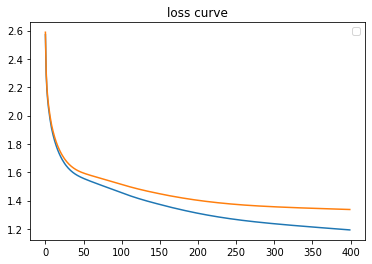

No handles with labels found to put in legend.


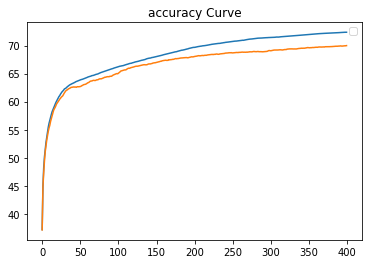

In [38]:
nn = Neural_Network([128,64,10])
nn.train(trainX, trainY, batch_size = 128, epochs = 400, \
         learningRate = 0.1, validationX = validX, validationY = validY)

In [39]:
nn.saveModel("BestModelCNN")

In [40]:
nn.loadModel('BestModelCNN.npz')
nn.accuracy(testX,testY)

70.5

In [41]:
from sklearn.metrics import confusion_matrix
y_pred = nn.predict(testX)
p = np.argmax(y_pred, axis=1)
y = np.argmax(test_set_y, axis=1)
confusion_matrix(y, p)

array([[ 769,    3,   37,   29,   20,   17,   26,   14,   64,    1],
       [   1, 1104,    6,    3,    2,    2,    2,    2,   11,    2],
       [  27,   11,  741,   80,   47,   11,   15,   31,   65,    4],
       [  11,   15,  101,  608,   43,   32,   18,   23,  149,   10],
       [  16,    8,   35,   29,  661,    7,   38,   11,  107,   70],
       [  15,    6,   42,  134,   38,  522,   18,   11,   97,    9],
       [  41,    7,   24,   39,   66,   43,  651,    3,   79,    5],
       [  11,   12,   89,   40,   47,   12,    2,  719,   65,   31],
       [  22,    4,   31,   38,   36,   23,   17,    7,  783,   13],
       [  12,    7,   47,   65,  198,   17,   14,   28,  129,  492]],
      dtype=int64)